In [45]:
import numpy as np
import pandas as pd
import os

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import gc
import json
from keras_preprocessing.text import tokenizer_from_json
from keras.models import model_from_json

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)

In [47]:
alexa = pd.read_csv('SentimentAnalysis/amazon_alexa.tsv', 
                    delimiter = '\t' ,usecols = ['verified_reviews' , 'feedback'] )

In [48]:
alexa = alexa.rename(columns={'verified_reviews':'reviews', 'feedback':'sentiment'})
display(alexa['sentiment'].value_counts()/alexa.shape[0]*100)
print('Shape of Dataset -> ' , alexa.shape)
display(alexa.sample(5))

1    91.84127
0     8.15873
Name: sentiment, dtype: float64

Shape of Dataset ->  (3150, 2)


,reviews,sentiment
2791,My three year old loves it. Good for doing basic household tasks. We're going to add a few smart outlets and bulbs.,1
1045,Very useful,1
2166,Love the fire stick and the amazon customer service!!!,1
534,Amazon doesn't disappoint.,1
1827,IT SEEMS TO BE OK BUT THE INSTRUCTIONS ARE WEAK AND I CAN NOT SEEM TO GET IT TO WORK. I AM GOING TO GET MY TECHY FRIEND TO HELP ME OUT AND I WILL UPDATE YOU LATER,1


In [5]:
twitter = pd.read_csv('SentimentAnalysis/Sentiment Analysis Dataset 2.csv', skiprows=[8835,535881] , usecols = ['Sentiment' , 'SentimentText'])
twitter = twitter.rename(columns = {'Sentiment': 'sentiment' , 'SentimentText':'reviews'})
display(twitter['sentiment'].value_counts()/twitter.shape[0]*100)
print('Shape of Dataset -> ' , twitter.shape)
display(twitter.sample(6))

1    50.055175
0    49.944825
Name: sentiment, dtype: float64

Shape of Dataset ->  (1578612, 2)


,sentiment,reviews
871261,0,I hate this place. I want to go home
1165162,0,put my dog to sleep I love you abby RIP&lt;3
1236406,1,Thanks to the lovely folks who endorsed me for #followfriday &amp; a great big welcome to those who were foolish enough to listen to them
1297236,1,Was in Dungeness during the week... That is one odd but fascinating place
703689,1,Good morning!!!! Yes is 5:57am
74018,0,@annavillanueva YEAH! hahahaha did you get fully loaded or that other one that you ordered last time? :O


In [6]:
imdb = pd.read_csv('SentimentAnalysis/imdb_master.csv', encoding = "ISO-8859-1")
imdb=imdb[imdb['label']!='unsup']
#Preprocessing
imdb=imdb.drop(['Unnamed: 0','type','file'],axis=1)
imdb.label[imdb.label == 'neg'] = 0
imdb.label[imdb.label == 'pos'] = 1
imdb=imdb.rename(columns = {'label': 'sentiment' , 'review':'reviews'})
display(imdb['sentiment'].value_counts()/imdb.shape[0]*100)
print('Shape of Dataset -> ' , imdb.shape)
display(imdb.sample(5))

0    50.0
1    50.0
Name: sentiment, dtype: float64

Shape of Dataset ->  (50000, 2)


,reviews,sentiment
32592,"Do we really need any more narcissistic garbage on the Baby Boomer generation? Technically, I am a Boomer, though at the time when all the ""idealistic youths"" of the '60s were reading Marx, burning their draft cards, and generally prolonging a war which destroyed tens of thousands of lives; I was still in grade school. But I remember them well, and 9 out of 10 were just moronic fools, who would believe anything as long as it was destructive.<br /><br />This is just another excercise in self-...",0
4931,"One Night at McCool's wants you to think it is a hip and clever black comedy. It pushes its ""quirky"" characters and ""outrageous"" situations at the viewer like a crack dealer making overtime. The premise is about a gold digging woman, named Jewel who dates men to get them to steal and sometimes murder, so she can have all the worldly possesions she so desperately desires. You know, this wouldn't be a bad strategy, if she chased after rich guys. This film really wants one to believe that a fox...",0
21562,I sell the dead revolves around convicted grave robber Arthur Blake. Blake's friend and fellow grave robber Willie Grimes has just been executed and Blake is going to follow suit the next morning. While he sits in his cell awaiting his execution a priest named Father Duffy comes in and asks him if he will tell all he has seen as a grave robber. He then proceeds to give Father Duffy a quasi biography of his more interesting exploits.<br /><br />The plot pretty much consists of several inciden...,1
4789,"It's too kind to call this a ""fictionalized"" account of the Barker gang. They got the names right, but that's about it.<br /><br />Russell is still hot, I'll grant you that, but this is not the real Ma Barker, who basically took care of the boys by cooking and assisting when they moved around the country, not by planning or participating in the crimes. I think it would have been far more interesting to present the real story of a middle-aged woman caught up in the criminal activities of her ...",0
23320,"Gene Roddenberry never let his fans down. His death ended Sci-Fi legacy that will never be matched. Earth: The Final Conflict was proof! His pilot film and the first 2 Seasons were well written and meticulously produced, but somewhere along the way the Roddenberry touch was lost. The loss of lead, Kevin Kilner (William Boone) definitely hurt the series as he was a vital part of what made it work. The story involves the human race being visited by the Taelons, an extra-terrestrial race who du...",1


In [7]:
data = pd.concat([alexa, twitter , imdb], axis= 0)
del alexa , twitter , imdb
gc.collect()

0

In [8]:
print(data.shape)
display(data.sample(5))
data['sentiment'].value_counts()/data.shape[0]*100

(1631762, 2)


,reviews,sentiment
405167,@normacd obviously norm.... off to the big (little) city of Barcelona today for lunch with folks.... xx,1
880197,@jevygurl Hate how? Like compare him to another character for me so I know your level of hate,1
365398,"@mileycyrus I'm a brazilian fan! please, send me a message!",1
1354316,working on ghostcogs while waiting for @zara_eyedea,1
674163,@C_Elizabethxo Thats great,1


1    50.134149
0    49.865851
Name: sentiment, dtype: float64

In [9]:
data = data.sample(frac= 0.05 , random_state = 10)

In [10]:
from spacy.lang.en.stop_words import STOP_WORDS
# stop_words = stopwords.words("english")
stop_words = STOP_WORDS
stemmer = SnowballStemmer("english")
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|<.*?>|[^A-Za-z0-9]+"
Emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    text = re.sub(Emoji_pattern, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [11]:
%%time
data.reviews = data.reviews.apply(lambda x: preprocess(x))

CPU times: user 1.39 s, sys: 22.8 ms, total: 1.41 s
Wall time: 1.42 s


In [12]:
data.head(5)

,reviews,sentiment
173995,theme,0
1157578,paid rent got free 6 pack,1
612797,coach horses come meet,1
179102,yea want ice cream walmart ben jerrys wanna hahahaha jk,1
749275,sounds interesting learned caring born quot gene quot,1


In [13]:
%%time
documents = [_text.split() for _text in data.reviews] 

CPU times: user 110 ms, sys: 5.01 ms, total: 115 ms
Wall time: 114 ms


MODEL-1

*WORD-2-VEC MODEL FOR EMBEDDING

In [14]:
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)


w2v_model.build_vocab(documents)

In [15]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 8456


In [16]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 1min 4s, sys: 448 ms, total: 1min 4s
Wall time: 13.6 s


(21323743, 26804608)

In [17]:
w2v_model.wv.most_similar(positive=['awesome'],topn=100)
# [x[0] for x in w2v_model.most_similar("awesome")]

[('awsome', 0.40734413266181946),
 ('amazing', 0.38628339767456055),
 ('cool', 0.359382301568985),
 ('fab', 0.3329111933708191),
 ('vid', 0.31347692012786865),
 ('great', 0.3107207119464874),
 ('excited', 0.2959449589252472),
 ('mtv', 0.2958347499370575),
 ('rock', 0.27967026829719543),
 ('selena', 0.27461400628089905),
 ('wow', 0.27054041624069214),
 ('yah', 0.26974037289619446),
 ('demi', 0.2658131420612335),
 ('ahhhh', 0.26257601380348206),
 ('loooove', 0.2570333182811737),
 ('favs', 0.2551291584968567),
 ('sucky', 0.2550903856754303),
 ('hangover', 0.25481411814689636),
 ('fantastic', 0.2530219554901123),
 ('woop', 0.2529413402080536),
 ('crazy', 0.2504613697528839),
 ('pumped', 0.24983370304107666),
 ('coldplay', 0.246983140707016),
 ('eurovision', 0.24672405421733856),
 ('rocks', 0.24513593316078186),
 ('btw', 0.2448856681585312),
 ('yeh', 0.24488119781017303),
 ('blast', 0.244490385055542),
 ('norway', 0.2439354807138443),
 ('dope', 0.2437485009431839),
 ('lovin', 0.242633149027

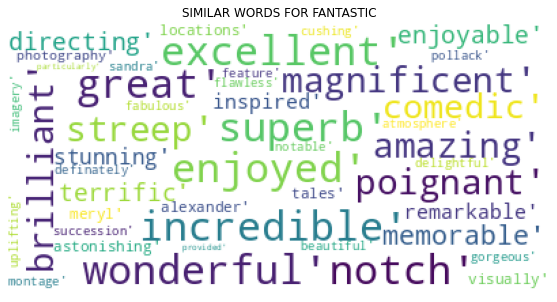

In [18]:
from wordcloud import WordCloud
plt.figure(figsize=(10,5))
wordcloud = WordCloud(background_color="white",
                      stopwords = STOP_WORDS,
                      max_words=45,
                      max_font_size=30,
                      random_state=42
                     ).generate(str([x[0] for x in w2v_model.wv.most_similar("fantastic",topn=100)]))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("SIMILAR WORDS FOR FANTASTIC")
plt.show()

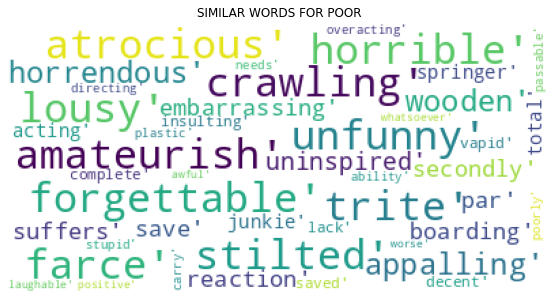

In [19]:
plt.figure(figsize=(10,5))
wordcloud = WordCloud(background_color="white",
                      stopwords = STOP_WORDS,
                      max_words=45,
                      max_font_size=30,
                      random_state=42
                     ).generate(str([x[0] for x in w2v_model.wv.most_similar("poor",topn=100)]))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("SIMILAR WORDS FOR POOR")
plt.show()

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.reviews)
vocab_size = len(tokenizer.word_index)+1
print('Vocab Size is ',vocab_size)

Vocab Size is  64003


In [39]:
SEQUENCE_LENGTH = 300
EPOCHS = 3
BATCH_SIZE = 2048

In [22]:
%%time 
x_data = pad_sequences(tokenizer.texts_to_sequences(data.reviews) , maxlen = SEQUENCE_LENGTH)

CPU times: user 1.02 s, sys: 23.5 ms, total: 1.04 s
Wall time: 1.04 s


In [23]:
y_data = data.sentiment
print(x_data.shape)
print(y_data.shape)
y_data = y_data.values.reshape(-1,1)

(81588, 300)
(81588,)


In [24]:
w2v_model.wv['sample'].shape

(300,)

In [25]:
embedding_matrix = np.zeros((vocab_size , W2V_SIZE))
for word , i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(64003, 300)


In [26]:
embedding_layer = Embedding( vocab_size , W2V_SIZE , weights = [embedding_matrix] , input_length = SEQUENCE_LENGTH, trainable = False)
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128 , dropout = 0.2 , recurrent_dropout = 0.2 ,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, dropout = 0.2 , recurrent_dropout = 0.2 ))
model.add(Dropout(0.1))
model.add(Dense(1,activation = 'sigmoid'))
model.summary()

2022-08-01 18:38:29.434717: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          19200900  
                                                                 
 lstm (LSTM)                 (None, 300, 128)          219648    
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 19,470,021
Trainable params: 269,121
Non-t

In [36]:
model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

# ReduceLRonPlateau is to reduce Learning rate when model stopeed improving
# Early Stopping to stop learning when staturation is reached.

In [32]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]

    return {"score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:

%%time 
history = model.fit(tf.convert_to_tensor(x_data, dtype=tf.float32), 
                    tf.convert_to_tensor(y_data, dtype=tf.float32), 
                    batch_size = BATCH_SIZE , epochs = EPOCHS , validation_split = 0.1  , verbose = 1 , callbacks = callbacks)


Epoch 1/3
23/36 [==================>...........] - ETA: 1:08:52 - loss: 0.5060 - accuracy: 0.7494

In [33]:
print(predict('i am Happy'))
print(predict('i not feeling so great .Little Rest can help but you decide what should i do next '))
print(predict('i am sitting in library for 6 hours . i learned alot but i am tired'))
print(predict('i am tired'))
print(predict('good is not good'))
print(predict('bad is not good'))
print(predict('good is not bad'))
print(predict('how i can end up here'))

{'score': 0.7945541143417358, 'elapsed_time': 0.0917809009552002}
{'score': 0.6135411262512207, 'elapsed_time': 0.0704340934753418}
{'score': 0.10607945919036865, 'elapsed_time': 0.07268404960632324}
{'score': 0.33189937472343445, 'elapsed_time': 0.07976913452148438}
{'score': 0.8332527875900269, 'elapsed_time': 0.06886982917785645}
{'score': 0.31325066089630127, 'elapsed_time': 0.06631183624267578}
{'score': 0.44972291588783264, 'elapsed_time': 0.07059097290039062}
{'score': 0.48638176918029785, 'elapsed_time': 0.06924176216125488}


In [34]:
model.save_weights('model_weights.h5')
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())
    
model.save('entire_model.h5')
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))